## Neural Style Transfer with PyTorch

In [1]:
!pip install torch torchvision

In [2]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


## Loading VGG Pretrained Model

In [3]:
import torch 
from torchvision import models

vgg = models.vgg19(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# vgg has features , linear, classifier part ; we dont need classifier part for vgg

vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:

# We dont want to update parameters as we r going to use pretrained weight.

for parameters in vgg.parameters():
 parameters.requires_grad_(False)


# in pytorch we use cuda to move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)      

vgg.to(device)     


cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Preprocess image

In [12]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path,max_size = 500):
  image = Image.open(img_path).convert('RGB')
   
  if max(image.size) > max_size :
          size = max_size
  else:
          size = max(image.size)

  ##transforming img
  img_transforms  = T.Compose([
                             T.Resize(size),
                             T.ToTensor(),  # (224,224,3)  ==> (3,224,224)
                             T.Normalize(mean = [0.485, 0.456, 0.406],
                                        std = [0.229, 0.224, 0.225])
  ])

  image = img_transforms(image)
  image = image.unsqueeze(0)      #   (3,224,224)  => (1,3,224,224)(batch_size,channel,heightofimg,widthofimg)
  return image

In [69]:
content_p =  preprocess('/content/Project-NST/spiderman.jpg')
style_p   = preprocess('/content/Project-NST/style10.jpg')

content_p  = content_p.to(device)
style_p  = style_p.to(device)

print("Content Shape", content_p.shape)
print("Style Shape",style_p.shape)


Content Shape torch.Size([1, 3, 500, 888])
Style Shape torch.Size([1, 3, 500, 765])


## Deprocess image

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
 image = tensor.to('cpu').clone()
 image = image.numpy()            # convert to numpy format from tensor format
 image = image.squeeze(0)         # (1,3,244,244)  --> (3,244,244)
 image = image.transpose(1,2,0)   #(3,244,244)  --> (244,244,3)
 image = image * np.array([0.299, 0.224, 0.225])  + np.array([0.485, 0.456, 0.406])
 image = image.clip(0,1)

 return image

In [71]:

content_d = deprocess(content_p)
style_d = deprocess(style_p)

print("Deprocess content: " , content_d.shape)
print("Deprocess style: " , style_d.shape)


Deprocess content:  (500, 888, 3)
Deprocess style:  (500, 765, 3)


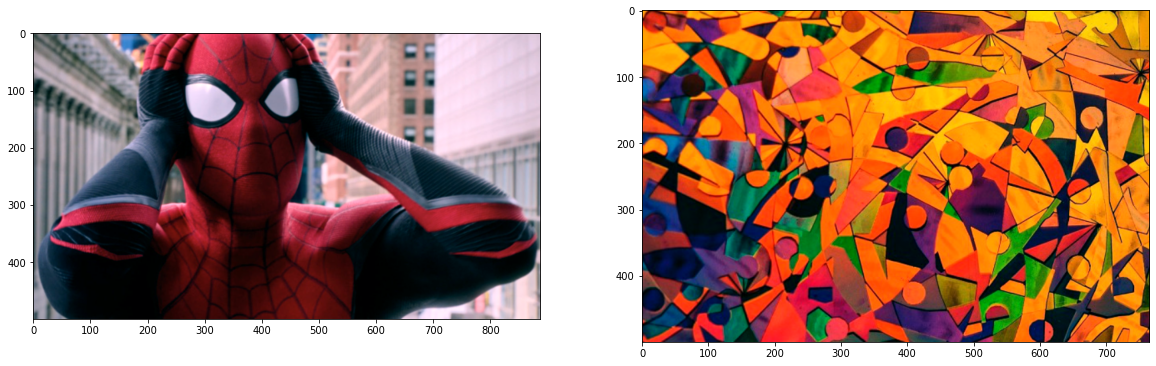

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))

ax1.imshow(content_d)
ax2.imshow(style_d)


## Get content,style features and create gram matrix

In [73]:
def get_features(image,model):
    layers = {
               '0' : 'conv1_1',
               '5' : 'conv2_1',
               '10' : 'conv3_1',
               '19': 'conv4_1',
               '21':'conv4_2',  #content_feature
               '28': 'conv5_1'
    }
    x = image
    Features = {}
   
    for name,layer in model._modules.items():
          x = layer(x)
          if name in layers:
                  Features[layers[name]] = x
    return Features

In [74]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p,vgg)

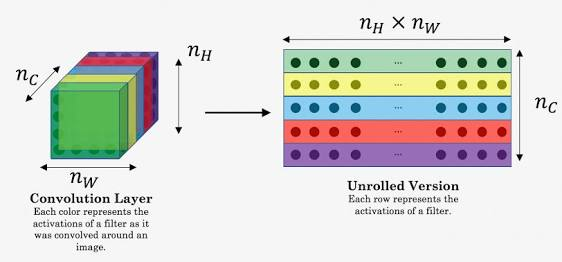

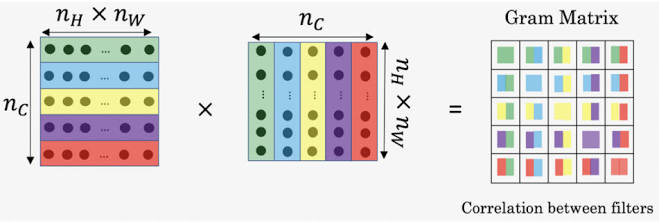

In [75]:
##Gram matrix  --- filters -> unroll -> unrolled * unrolled.Transpose --> Gram matrix

def gram_matrix(tensor):
   b,c,h,w = tensor.size()
   tensor = tensor.view(c,h*w)
   gram = torch.mm(tensor,tensor.t())
   return gram


In [76]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}


## Creating Style and Content loss function

In [77]:
def content_loss(target_conv4_2,content_conv4_2):

  loss = torch.mean((target_conv4_2-content_conv4_2) ** 2)
  return loss

In [78]:
style_weights = {
         'conv1_1' : 1.0,
         'conv2_1' : 0.75,
         'conv3_1' : 0.2 ,
         'conv4_1' : 0.2,
         'conv5_1' : 0.2
}

In [79]:
def style_loss(style_weights,target_features,style_grams):
   loss = 0
   for layer in style_weights:
      target_f = target_features[layer]
      target_gram = gram_matrix(target_f)
      style_gram = style_grams[layer]
      b,c,h,w = target_f.shape
      layer_loss = style_weights[layer] * torch.mean((target_gram  - style_gram) ** 2)
      loss += layer_loss/(c*h*w)
   return loss

In [80]:
#creating the target nst image 
##Initializing target image either random noise or  content image. Here we used content image. Hence content loss is zero here.
target = content_p.clone().requires_grad_(True).to(device) 
target_f = get_features(target,vgg)
print("Content loss : " , content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style loss : ",style_loss(style_weights,target_f,style_grams))


Content loss :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style loss :  tensor(1267.0010, device='cuda:0', grad_fn=<AddBackward0>)


## Training loop

In [81]:
from torch import optim
optimizer = optim.Adam([target],lr = 0.003)   # Generally we optimize weights here pixels are used.

alpha = 1
beta = 1e5
epochs = 2000
show_every = 500   # It shows the result for every 500 steps

In [82]:
def total_loss(c_loss,s_loss, alpha,beta):
  loss = alpha * c_loss + beta * s_loss
  return loss


In [83]:

results = []
for i in range(epochs+1):
   target_f = get_features(target,vgg)
   c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
   s_loss = style_loss(style_weights,target_f,style_grams)
   t_loss = total_loss(c_loss,s_loss,alpha,beta)

   optimizer.zero_grad()
   t_loss.backward()
   optimizer.step()

   if i % show_every == 0:
      print("Total Loss at Epoch {} : {}".format(i,t_loss))
      results.append(deprocess(target.detach()))


Total Loss at Epoch 0 : 126700096.0
Total Loss at Epoch 500 : 16864016.0
Total Loss at Epoch 1000 : 6538108.5
Total Loss at Epoch 1500 : 2505165.75
Total Loss at Epoch 2000 : 1116976.5


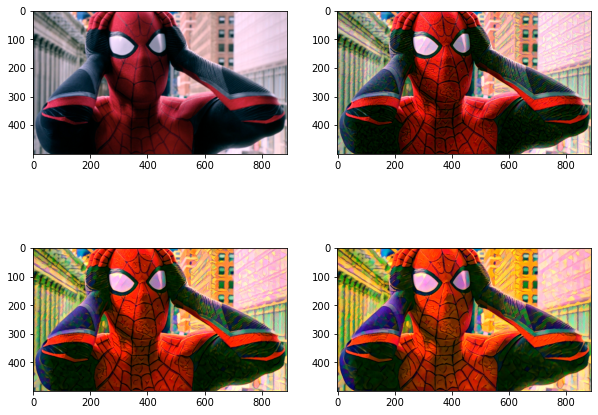

In [84]:
results.pop()
plt.figure(figsize = (10,8))

for i in range(len(results)):
  plt.subplot(2,2,i+1)
  plt.imshow(results[i])
plt.show()

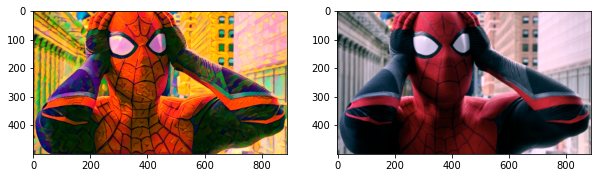

In [85]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)   #content dont have gradients to detach

fig, (ax1,ax2)  = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)